In [1]:
from zoish.feature_selectors.optunashap import OptunaShapFeatureSelector
import logging
import numpy as np
import pandas as pd
import xgboost
import xgbse
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
from xgbse.converters import convert_to_structured
from xgbse.metrics import concordance_index, approx_brier_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
[I 2022-09-07 06:22:45,742] A new study created in memory with name: no-name-c465a0b4-fa9e-4c60-bd38-47cdc0e3d01c


<Figure size 432x288 with 0 Axes>

# Install pytorch, pycox needs it

In [2]:
!pip3 install torch torchvision torchaudio



[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


# Example : XGBoost Survival Embeddings (XGBSEKaplanNeighbors)
For more information refer to this link :
https://loft-br.github.io/xgboost-survival-embeddings/examples/confidence_interval.html

# Data

In [3]:
from pycox.datasets import metabric
# read data metabric
data = metabric.read_df()
data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
2,5.920251,6.776564,12.431715,5.873857,0.0,1.0,0.0,1.0,48.439999,140.233337,0
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1


# Define labels in this example: 

y for feature selection (if you want to feature selection based on event)
y_fs = data['event']

Also in grid_xgbse bellow,  xgbse_focus should be set = "event",


y for feature selection (if you want to perform feature selection based on duration)
y_fs = data['duration']

Also in grid_xgbse bellow,  xgbse_focus should be set = "duration",



In [4]:

# splitting to X, T, E format
X = data.drop(['duration', 'event'], axis=1)
T = data['duration']
E = data['event']
y = convert_to_structured(T, E)
# y for for feature selection (if you want do feature selection based on event)
# y_fs = data[['event']]
# also in grid_xgbse should set xgbse_model_needed = "classification",


# y for for feature selection (if you want do feature selection based on duration)
# y_fs = data[['duration']]
# also in grid_xgbse should set xgbse_model_needed = "regression",

y_fs = data[['duration']]



In [5]:
y_fs.head()

,duration
0,99.333336
1,95.733330
2,140.233337
3,239.300003
4,56.933334


# Train test split for feature selection and for the model itself

splitting between train and validation (the following uses for the feature selection step - random_state should be the same in both)
 - X_train, X_test, y_train_fs, y_test_fs = train_test_split(X, y_fs, test_size=1/3, random_state = 0)

splitting between train and validation (the following uses for the main model - random_state should be the same in both)
- _ , _ , y_train, y_test = train_test_split(X, y, test_size=1/3, random_state = 0)


In [6]:
# splitting between train, and validation (the following is for feature selection step - random_state should be same in both)
X_train, X_test, y_train_fs, y_test_fs = train_test_split(X, y_fs, test_size=1/3, random_state = 0)
# splitting between train, and validation (the following is for fit main model - random_state should be same in both)
_ , _ , y_train, y_test = train_test_split(X, y, test_size=1/3, random_state = 0)

TIME_BINS = np.arange(15, 315, 15)
TIME_BINS


array([ 15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180, 195,
       210, 225, 240, 255, 270, 285, 300])

# Define Feature selector and set its arguments  

The feature selector in this example (or when the focus is on "duration") will use XGBRegressor.

So estimator_params should be matched with XGBRegressor.

In [7]:
optuna_xgbse = OptunaShapFeatureSelector(
        # general argument setting        
        verbose=1,
        random_state=0,
        logging_basicConfig = None,
        # general argument setting        
        n_features=5,
        list_of_obligatory_features_that_must_be_in_model=[],
        list_of_features_to_drop_before_any_selection=[],
        # shap argument setting        
        estimator=xgbse.XGBSEKaplanNeighbors(),
        estimator_params={
        "max_depth": [4, 5],
        "min_child_weight": [0.1, 0.9],
        "gamma": [1, 9],
        },
        # shap arguments
        model_output="raw", 
        feature_perturbation="interventional", 
        algorithm="auto", 
        shap_n_jobs=-1, 
        memory_tolerance=-1, 
        feature_names=None, 
        approximate=False, 
        shortcut=False, 
        plot_shap_summary=False,
        save_shap_summary_plot=True,
        path_to_save_plot = './summary_plot.png',
        shap_fig = plt.figure(),
        ## optuna params
        test_size=0.33,
        with_stratified = False,
        performance_metric = 'r2',
        # optuna study init params
        study = optuna.create_study(
            storage = None,
            sampler = TPESampler(),
            pruner= HyperbandPruner(),
            study_name  = None,
            direction = "maximize",
            load_if_exists = False,
            directions  = None,
            ),
        study_optimize_objective_n_trials=10, 
        xgbse_focus = "duration",


)


[I 2022-09-07 06:22:49,471] A new study created in memory with name: no-name-f4d9a02d-ceca-4105-b96a-92de150ed00c
root - INFO - Setting value for logging_basicConfig
root - INFO - Setting value for verbose
root - INFO - Setting value for xgbse_focus
root - INFO - Setting value for random_state
root - INFO - Setting value for n_features
root - INFO - Setting value for list_of_obligatory_features_that_must_be_in_model
root - INFO - Setting value for list of features to drop before any selection
root - INFO - Setting value for estimator
root - INFO - Getting value for estimator
root - INFO - XGBSEKaplanNeighbors(xgb_params={'aft_loss_distribution': 'normal',
                                 'aft_loss_distribution_scale': 1,
                                 'booster': 'dart', 'colsample_bynode': 0.5,
                                 'eval_metric': 'aft-nloglik',
                                 'learning_rate': 0.05, 'max_depth': 8,
                                 'min_child_weight': 50,


<Figure size 432x288 with 0 Axes>

# Build sklearn Pipeline 

(in this example only feature selector, because features already in
form of numbers)

root - INFO - Getting value for estimator
root - INFO - Getting value for performance metric
root - INFO - Getting value for estimator_params
root - INFO - Getting value for verbose
root - INFO - Getting value for test_size
root - INFO - Getting value for random_state
root - INFO - Getting value for study
root - INFO - Getting value for study optimize objective
root - INFO - Getting value for study_optimize_objective_n_trials
root - INFO - Getting value for study_optimize_objective_timeout
root - INFO - Getting value for study_optimize_n_jobs
root - INFO - Getting value for study_optimize_catch
root - INFO - Getting value for study_optimize_callbacks
root - INFO - Getting value for study_optimize_gc_after_trial
root - INFO - Getting value for study_optimize_show_progress_bar
root - INFO - Getting value for with_stratified
root - INFO - Getting value for xgbse_focus


[0]	validation-rmse:116.34125[0]	validation-rmse:116.34125

[0]	validation-rmse:116.34125
[1]	validation-rmse:96.93900
[1]	validation-rmse:96.93900
[1]	validation-rmse:96.93900
[2]	validation-rmse:85.74233
[0]	validation-rmse:116.34125
[2]	validation-rmse:85.74233
[2]	validation-rmse:85.74233
[0]	validation-rmse:116.34125
[0]	validation-rmse:116.34125
[1]	validation-rmse:96.93900
[3]	validation-rmse:80.67430
[3]	validation-rmse:80.67430
[3]	validation-rmse:80.67430
[1]	validation-rmse:96.93900
[2]	validation-rmse:85.74233
[1]	validation-rmse:96.93900
[0]	validation-rmse:116.34125
[4]	validation-rmse:77.17819
[4]	validation-rmse:77.17819
[4]	validation-rmse:77.17819
[2]	validation-rmse:85.74233
[0]	validation-rmse:116.47100
[3]	validation-rmse:80.67430
[5]	validation-rmse:75.68631
[2]	validation-rmse:85.74233
[5]	validation-rmse:75.68631
[1]	validation-rmse:96.93900
[5]	validation-rmse:75.68631
[3]	validation-rmse:80.67430
[4]	validation-rmse:77.17819[6]	validation-rmse:74.96988

[6]	va

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
The distribution is specified by [0.1, 0.9] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 0.1].


[8]	validation-rmse:74.60984[4]	validation-rmse:77.17819

[8]	validation-rmse:74.60984
[7]	validation-rmse:74.80721
[3]	validation-rmse:80.38959
[6]	validation-rmse:74.96988
[7]	validation-rmse:74.80721
[9]	validation-rmse:74.85212
[5]	validation-rmse:75.68631[9]	validation-rmse:74.85212

[8]	validation-rmse:74.60984[9]	validation-rmse:74.85212

[7]	validation-rmse:74.80721


[I 2022-09-07 06:22:49,691] Trial 2 finished with value: 0.01724778885129019 and parameters: {'max_depth': 4, 'min_child_weight': 0, 'gamma': 1.344605670850771}. Best is trial 2 with value: 0.01724778885129019.


[8]	validation-rmse:74.60984[4]	validation-rmse:77.76430
[9]	validation-rmse:74.85212

[6]	validation-rmse:74.96988


[I 2022-09-07 06:22:49,695] Trial 0 finished with value: 0.01724778885129019 and parameters: {'max_depth': 4, 'min_child_weight': 0, 'gamma': 5.339052358468782}. Best is trial 2 with value: 0.01724778885129019.
[I 2022-09-07 06:22:49,698] Trial 1 finished with value: 0.01724778885129019 and parameters: {'max_depth': 4, 'min_child_weight': 0, 'gamma': 8.598167746795482}. Best is trial 2 with value: 0.01724778885129019.


[8]	validation-rmse:74.60984
[7]	validation-rmse:74.80721[5]	validation-rmse:76.58114

[9]	validation-rmse:74.85212

[I 2022-09-07 06:22:49,707] Trial 7 finished with value: 0.01724778885129019 and parameters: {'max_depth': 4, 'min_child_weight': 0, 'gamma': 2.7844916962753503}. Best is trial 2 with value: 0.01724778885129019.



[9]	validation-rmse:74.85212
[8]	validation-rmse:74.60984[6]	validation-rmse:76.15698



The distribution is specified by [0.1, 0.9] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 0.1].
[I 2022-09-07 06:22:49,720] Trial 6 finished with value: 0.01724778885129019 and parameters: {'max_depth': 4, 'min_child_weight': 0, 'gamma': 4.640684948017875}. Best is trial 2 with value: 0.01724778885129019.
The distribution is specified by [0.1, 0.9] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 0.1].
[I 2022-09-07 06:22:49,724] Trial 4 finished with value: 0.01724778885129019 and parameters: {'max_depth': 4, 'min_child_weight': 0, 'gamma': 6.249286842297109}. Best is trial 2 with value: 0.01724778885129019.


[9]	validation-rmse:74.85212[7]	validation-rmse:75.92025

[0]	validation-rmse:116.34125


[I 2022-09-07 06:22:49,732] Trial 3 finished with value: 0.01724778885129019 and parameters: {'max_depth': 4, 'min_child_weight': 0, 'gamma': 2.2125479637879284}. Best is trial 2 with value: 0.01724778885129019.


[0]	validation-rmse:116.47100
[8]	validation-rmse:75.67320
[1]	validation-rmse:96.93900
[9]	validation-rmse:75.68884
[1]	validation-rmse:97.50656
[2]	validation-rmse:85.74233


[I 2022-09-07 06:22:49,747] Trial 5 finished with value: -0.004846115711912846 and parameters: {'max_depth': 5, 'min_child_weight': 0, 'gamma': 1.0253063065608368}. Best is trial 2 with value: 0.01724778885129019.


[2]	validation-rmse:86.02381
[3]	validation-rmse:80.67430
[3]	validation-rmse:80.38959
[4]	validation-rmse:77.17819
[5]	validation-rmse:75.68631
[4]	validation-rmse:77.76430
[6]	validation-rmse:74.96988
[5]	validation-rmse:76.58114
[7]	validation-rmse:74.80721
[6]	validation-rmse:76.15698
[8]	validation-rmse:74.60984
[7]	validation-rmse:75.92025
[9]	validation-rmse:74.85212
[8]	validation-rmse:75.67320


[I 2022-09-07 06:22:49,784] Trial 9 finished with value: 0.01724778885129019 and parameters: {'max_depth': 4, 'min_child_weight': 0, 'gamma': 4.87322523170415}. Best is trial 2 with value: 0.01724778885129019.


[9]	validation-rmse:75.68884


[I 2022-09-07 06:22:49,799] Trial 8 finished with value: -0.004846115711912846 and parameters: {'max_depth': 5, 'min_child_weight': 0, 'gamma': 8.729215622244794}. Best is trial 2 with value: 0.01724778885129019.


{'max_depth': 4, 'min_child_weight': 0, 'gamma': 1.344605670850771}
[0]	validation-rmse:116.34125
[1]	validation-rmse:96.93900
[2]	validation-rmse:85.74233
[3]	validation-rmse:80.67430
[4]	validation-rmse:77.17819
[5]	validation-rmse:75.68631
[6]	validation-rmse:74.96988
[7]	validation-rmse:74.80721
[8]	validation-rmse:74.60984
[9]	validation-rmse:74.85212


root - INFO - Setting value for best estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for best estimator
root - INFO - Getting value for model_output
root - INFO - Getting value for feature perturbation
root - INFO - Getting value for algorithm
root - INFO - Getting value for shap_n_jobs
root - INFO - Getting value for memory_tolerance
root - INFO - Getting value for feature_names


XGBRegressor


root - INFO - Getting value for approximate
root - INFO - Getting value for shortcut
root - INFO - Getting value for plot shap summary
root - INFO - Getting value for save_shap_summary_plot
root - INFO - Getting value for n_features


.values =
array([[-2.05171872e+01,  3.49701147e+00,  1.21635859e+00, ...,
         4.61964133e+00, -1.12680848e-01,  4.53966749e+00],
       [-6.34295267e+00,  7.58534358e+00, -1.22623208e+01, ...,
         4.73083571e+00, -1.12680848e-01, -1.36199884e+01],
       [ 3.03174441e+00,  8.50356220e+00, -2.08184213e+01, ...,
         3.80822283e+00, -1.12680848e-01,  4.18465937e+00],
       ...,
       [ 6.69514964e+00,  2.31327843e+00,  1.70247070e+00, ...,
        -2.87580416e+01, -1.42007463e-02,  1.96700466e+01],
       [-1.69423441e+01, -1.27754553e+01,  5.55881561e+00, ...,
        -3.16229933e+01, -3.57449158e-02,  2.23570470e+01],
       [ 4.05584881e+00,  4.47072402e+00, -3.45506907e-01, ...,
        -1.82640919e+01, -6.82871809e-02, -3.82825404e+00]])

.base_values =
array([[122.60388172],
       [122.60388172],
       [122.60388172],
       ...,
       [122.60388172],
       [122.60388172],
       [122.60388172]])

.data =
array([[ 5.259714 ,  7.07262  , 11.602811 , ...,  0.     

root - INFO - Getting value for path_to_save_plot
root - INFO - Getting value for shap_fig
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
root - INFO - Setting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Setting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for n_features
root - INFO - Getting value for n_features
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df


    0          1
0  x0   4.280432
1  x1   7.762735
2  x2   3.644847
3  x3   3.302002
4  x4    4.60284
5  x5   1.319713
6  x6  10.035227
7  x7   0.152524
8  x8  12.944945
  column_name shap_importance
0          x0        4.280432
1          x1        7.762735
2          x2        3.644847
3          x3        3.302002
4          x4         4.60284
5          x5        1.319713
6          x6       10.035227
7          x7        0.152524
8          x8       12.944945
  column_name shap_importance
8          x8       12.944945
6          x6       10.035227
1          x1        7.762735
4          x4         4.60284
0          x0        4.280432
2          x2        3.644847
3          x3        3.302002
5          x5        1.319713
7          x7        0.152524
  column_name shap_importance
8          x8       12.944945
6          x6       10.035227
1          x1        7.762735
4          x4         4.60284
0          x0        4.280432


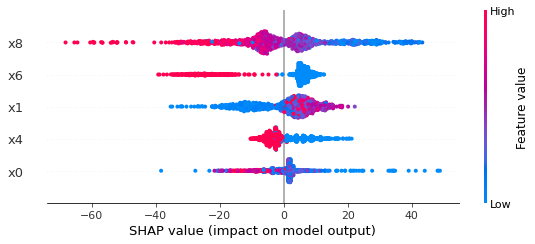

In [8]:

pipeline = Pipeline([
            # feature selection
            ('optuna_xgbse', optuna_xgbse),

 ])

X_train=pipeline.fit_transform(X_train,y_train_fs)


# Transform X_test

X_train already transformed (features already selected), it is time to transform X_text



In [9]:
X_test = pipeline.transform(X_test)

# Prepare for using XGBSEKaplanNeighbors and fit the model

Note that features already selected by the above pipeline


In [10]:
PARAMS_TREE = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'tree_method': 'hist',
    'max_depth': 10,
    'booster':'dart',
    'subsample': 1.0,
    'min_child_weight': 50,
    'colsample_bynode': 1.0
}

xgbse_model = xgbse.XGBSEKaplanNeighbors(PARAMS_TREE)
xgbse_model.fit(X_train, y_train, time_bins=TIME_BINS)
mean, upper_ci, lower_ci  = xgbse_model.predict(X_test,return_ci=True)



# To easily plot confidence intervals


In [11]:
# to easily plot confidence intervals
def plot_ci(mean, upper_ci, lower_ci, i=42, title='Probability of survival $P(T \geq t)$'):

    # plotting mean and confidence intervals
    plt.figure(figsize=(12, 4), dpi=120)
    plt.plot(mean.columns,mean.iloc[i])
    plt.fill_between(mean.columns, lower_ci.iloc[i], upper_ci.iloc[i], alpha=0.2)

    plt.title(title)
    plt.xlabel('Time [days]')
    plt.ylabel('Probability')
    plt.tight_layout()


# Check performance of the feature selector and model integrated

C-index: 0.6362251688624119
Avg. Brier Score: 0.17961582533009496


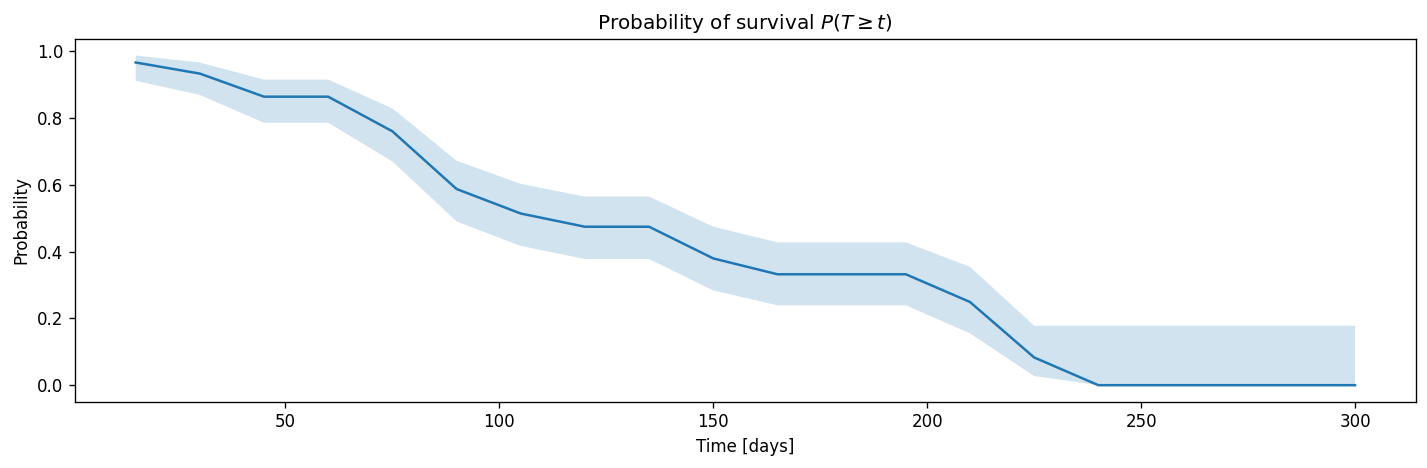

In [12]:
# print metrics
print(f"C-index: {concordance_index(y_test, mean)}")
print(f"Avg. Brier Score: {approx_brier_score(y_test, mean)}")

# plotting CIs
plot_ci(mean, upper_ci, lower_ci)



It is interesting to see that obtained results by using only selected five features are comparable to the original example in 

https://loft-br.github.io/xgboost-survival-embeddings/examples/confidence_interval.html

the model used all eight features with the same test and train data and parameters. 